# Milestone 3 - Regression Sim 

## Author - Lawrence Huang



## Instructions
For Milestone 3 you should

1. prepare the data via cleaning, normalization, encoding, et cetera; and
2. generate and evaluate a working model (linear, or time series).

#### Dataset: King County Housing dataset
#### Location for dataset: https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/kc_house_data.csv

#### Overall problem statement:  Predict the price of a house in King County.
Use case: A developer interested in acquiring properties in King County, Washington is interested in what home features (zip code, structure, etc) would yield a high price. 

#### Goal for Milestone 3: prepare the data for modeling as well as build an initial model that you will need to refine for Milestone 4.

In [1]:
# Load necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import datetime as dt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import scipy.stats as ss
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score

# Load and view data
url = 'https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/kc_house_data.csv'
house_orig = pd.read_csv(url)
house_orig.head()

# make a copy of the dataframe
house = house_orig.copy()

##### Data preparation

In [2]:
# all columns except date are of int/float type 
# find number of NANs/missing values
print('data types:')
print(house.dtypes)
print('\nnumber of nan values: {}'.format(house.isna().sum().sum()))

data types:
id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

number of nan values: 0


In [3]:
# drop id, since it appears to be independent of price 
# it is a "key", with with almost as many unique values as observations
print('unique values for id: {}'.format(house['id'].nunique()))
cols_to_drop = ['id']

unique values for id: 21436


In [4]:
# date may be useful as a feature, even though the data only spans 1 year
# change date to ordinal 
house['date'] = pd.to_datetime(house['date'])
house['date_ordinal']=house['date'].map(dt.datetime.toordinal)
cols_to_drop.append('date')

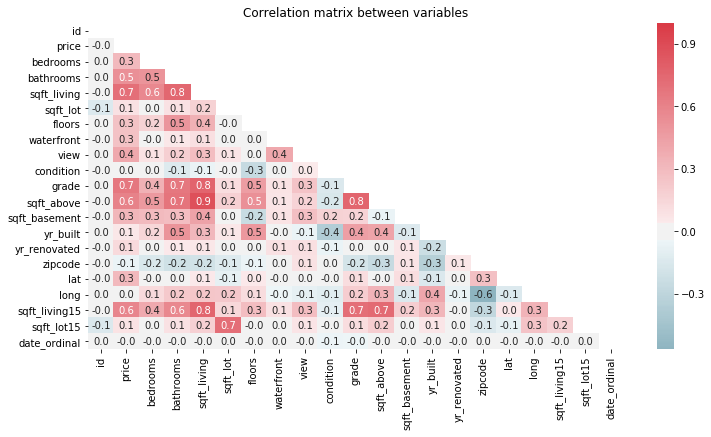

In [5]:
# Examine correlation between variables.
corrmat = house.corr()
mask = np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True) # diverging colormap
fig = plt.figure(figsize=(12,6))
ax = fig.gca()
sns.heatmap(corrmat, mask=mask, annot=True, cmap=cmap, fmt='.1f', center=0, ax=ax)
ax.set_title('Correlation matrix between variables')
plt.show()

In [6]:
# find pairs with highest correlations (corr coeff>0.6)
corrmat = house.corr().abs()
np.fill_diagonal(corrmat.values, np.nan)
corr_series = corrmat.unstack()
corr_series_ordered = corr_series.sort_values(ascending=False)
print('pairs with the highest correlation:\n(variable 1, variable 2, correlation coeff)')
corr_series_ordered[corr_series_ordered>0.6][::2]

pairs with the highest correlation:
(variable 1, variable 2, correlation coeff)


sqft_above     sqft_living    0.876597
grade          sqft_living    0.762704
sqft_living15  sqft_living    0.756420
grade          sqft_above     0.755923
bathrooms      sqft_living    0.754665
sqft_living15  sqft_above     0.731870
sqft_lot       sqft_lot15     0.718557
sqft_living15  grade          0.713202
price          sqft_living    0.702035
sqft_above     bathrooms      0.685342
price          grade          0.667434
bathrooms      grade          0.664983
sqft_above     price          0.605567
dtype: float64

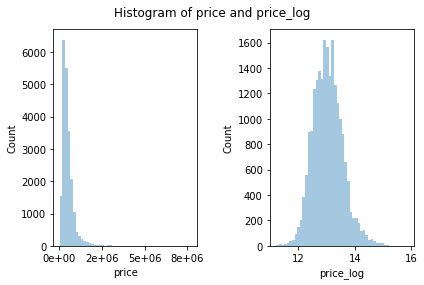

In [7]:
# price is positively-skewed with a long right tail; 
# a log transform creates a distribution closer to a normal distribution.
house['price_log'] = np.log(house['price'])

# plot histograms before and after log transform
fig, axs = plt.subplots(1,2)
sns.distplot(house['price'], kde=False, ax=axs[0])
axs[0].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
sns.distplot(house['price_log'], kde=False, ax=axs[1])
axs[0].set_ylabel('Count')
axs[1].set_ylabel('Count')
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.suptitle('Histogram of price and price_log')
plt.show()

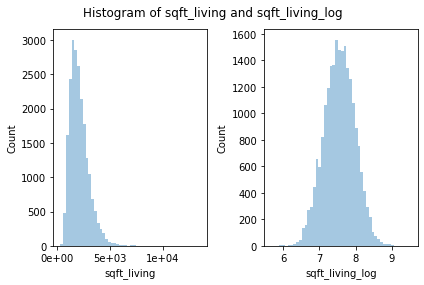

In [8]:
# sqft_living is positively-skewed with a long right tail; 
# a log transform creates a distribution closer to a normal distribution.
# Also, from Milestone 1, sqft_living_log also has a more linear relationship with price_log, compared to before log transform.
house['sqft_living_log'] = np.log(house['sqft_living'])

# plot histograms before and after log transform
fig, axs = plt.subplots(1,2)
sns.distplot(house['sqft_living'], kde=False, ax=axs[0])
axs[0].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
sns.distplot(house['sqft_living_log'], kde=False, ax=axs[1])
axs[0].set_ylabel('Count')
axs[1].set_ylabel('Count')
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.suptitle('Histogram of sqft_living and sqft_living_log')
plt.show()

cols_to_drop.append('sqft_living')

In [9]:
# sqft_living15, sqft_lot15 are colinear to other features of similar names (sqft_living, sqft_lot, respectively). 
# Differences between these similar named variables are unclear.
# drop sqft_living15, sqft_lot15
cols_to_drop.extend(['sqft_living15', 'sqft_lot15'])

In [10]:
# view, condition, grade are categorical because they have a small number of discrete numeric values and are qualitative.
# function to convert ordinal variables to category type
def custom_ordinal_encoder(col):
    cat_dtype = pd.api.types.CategoricalDtype(categories=sorted(house[col].unique()), ordered=True)
    return house[col].astype(cat_dtype)

# convert ordinal variables to category type
house['view_cat'] = custom_ordinal_encoder('view')
house['condition_cat'] = custom_ordinal_encoder('condition')
#house['grade_cat'] = custom_ordinal_encoder('grade')

# as shown above, grade is highly correlated with a number of variables (some of which also will not be selected for modeling):
# sqft_living, sqft_above, sqft_living15, bathrooms 
# exclude grade, which reduces the condition number of the model.
# when the condition number is large, there could be strong multicollinearity or other numerical problems.

cols_to_drop.extend(['view', 'condition', 'grade'])

In [11]:
# sqft_living = sqft_above + sqft_basement; there are many zeros in sqft_basement, so sqft_above dominates sqft_living.
# exclude sqft_above, keep just sqft_living_log
cols_to_drop.append('sqft_above')

In [12]:
# create new feature for house age from yr_built
house['years_old'] = house['date'].dt.year - house['yr_built']

# there are many zeros in yr_renovated; create new binary feature renovated to indicate if house has been renovated or not
house['renovated'] = house['yr_renovated'].apply(lambda yr: 0 if yr == 0 else 1)

cols_to_drop.extend(['yr_renovated', 'yr_built'])

In [13]:
# one hot encode the categorical column zipcode (no order in zipcodes)
house = pd.get_dummies(house, prefix='zip', columns=['zipcode'], drop_first=True)

In [14]:
# drop designated columns
house.drop(cols_to_drop, axis=1, inplace=True)

In [15]:
# define function that replaces outliers with the median 
# outliers defined as x > mean(x)+n*std(x) or x < mean(x)-n*std(x), where n could be defined in the function
# function was not used here because model metrics including RMSE and R2 become worse
if False:
    def replace_outlier(y, nstd):
            x = np.copy(y)
            LimitHi = np.mean(x) + nstd*np.std(x)
            LimitLo = np.mean(x) - nstd*np.std(x)
            # Create Flags for outliers 
            FlagBad = (x < LimitLo) | (x > LimitHi)
            # Replace outliers with the median
            x = x.astype(float) # since np.median returns float
            x[FlagBad] = np.median(x)
            return x
        
    # perform replacement on numeric columns
    num_cols = ['bedrooms', 'bathrooms', 'sqft_living_log', 'sqft_lot', 'floors', 'sqft_basement', 'lat', 'long', 'date_ordinal', 'years_old']    
    house[num_cols] = house[num_cols].apply(replace_outlier, nstd=5)

    # check replacement (for example on bedrooms):
    nstd = 5
    check1 = sum(house['bedrooms']==np.median(house['bedrooms']))
    check2 = sum(house_orig['bedrooms']==np.median(house_orig['bedrooms']))+sum(house_orig['bedrooms']>np.mean(house_orig['bedrooms'])+nstd*np.std(house_orig['bedrooms']))+sum(house_orig['bedrooms']<np.mean(house_orig['bedrooms'])-nstd*np.std(house_orig['bedrooms']))
    print(check1==check2)

##### Train/test split

In [16]:
# train/test split
# target
y = house['price_log']
# features
X = house.loc[:, ~house.columns.isin(['price', 'price_log'])]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
print('features: {}'.format(X.columns.values))

features: ['bedrooms' 'bathrooms' 'sqft_lot' 'floors' 'waterfront' 'sqft_basement'
 'lat' 'long' 'date_ordinal' 'sqft_living_log' 'view_cat' 'condition_cat'
 'years_old' 'renovated' 'zip_98002' 'zip_98003' 'zip_98004' 'zip_98005'
 'zip_98006' 'zip_98007' 'zip_98008' 'zip_98010' 'zip_98011' 'zip_98014'
 'zip_98019' 'zip_98022' 'zip_98023' 'zip_98024' 'zip_98027' 'zip_98028'
 'zip_98029' 'zip_98030' 'zip_98031' 'zip_98032' 'zip_98033' 'zip_98034'
 'zip_98038' 'zip_98039' 'zip_98040' 'zip_98042' 'zip_98045' 'zip_98052'
 'zip_98053' 'zip_98055' 'zip_98056' 'zip_98058' 'zip_98059' 'zip_98065'
 'zip_98070' 'zip_98072' 'zip_98074' 'zip_98075' 'zip_98077' 'zip_98092'
 'zip_98102' 'zip_98103' 'zip_98105' 'zip_98106' 'zip_98107' 'zip_98108'
 'zip_98109' 'zip_98112' 'zip_98115' 'zip_98116' 'zip_98117' 'zip_98118'
 'zip_98119' 'zip_98122' 'zip_98125' 'zip_98126' 'zip_98133' 'zip_98136'
 'zip_98144' 'zip_98146' 'zip_98148' 'zip_98155' 'zip_98166' 'zip_98168'
 'zip_98177' 'zip_98178' 'zip_98188' 'zi

In [17]:
# standardize numeric columns (z-score)
num_cols = ['bedrooms', 'bathrooms', 'sqft_living_log', 'sqft_lot', 'floors', 'sqft_basement', 'lat', 'long', 'date_ordinal', 'years_old']
scaler = StandardScaler().fit(X_train[num_cols])
X_train = X_train.copy()
X_test = X_test.copy()
X_train[num_cols] = scaler.transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

##### Baseline linear regression model

In [18]:
# Baseline linear regression model 
regressor = LinearRegression()
regressor.fit(X_train,y_train)

# predicted price_log 
y_pred_test_lr = regressor.predict(X_test)
y_pred_train_lr = regressor.predict(X_train)

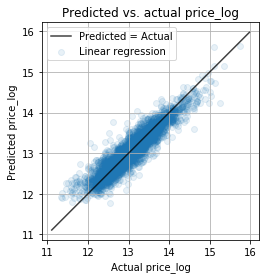

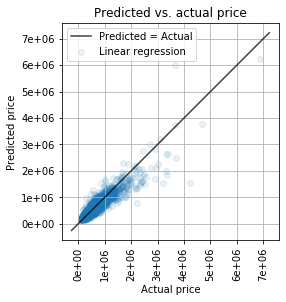

In [19]:
# predicted vs. observed plot
# price_log
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred_test_lr, label='Linear regression', alpha=0.1)
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=10, label='Predicted = Actual')
ax.set_xlabel('Actual price_log')
ax.set_ylabel('Predicted price_log')
ax.set_title('Predicted vs. actual price_log')
ax.set_aspect('equal')
ax.legend()
ax.grid()
plt.show()

# price
fig, ax = plt.subplots()
ax.scatter(np.exp(y_test), np.exp(y_pred_test_lr), label='Linear regression', alpha=0.1)
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=10, label='Predicted = Actual')
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
ax.set_xlabel('Actual price')
ax.set_ylabel('Predicted price')
ax.set_title('Predicted vs. actual price')
ax.set_aspect('equal')
ax.legend()
ax.grid()
ax.set_xticks(np.arange(0, ax.get_xlim()[1], 1e6))
ax.set_yticks(np.arange(0, ax.get_ylim()[1], 1e6))
plt.xticks(rotation=90)
plt.show()

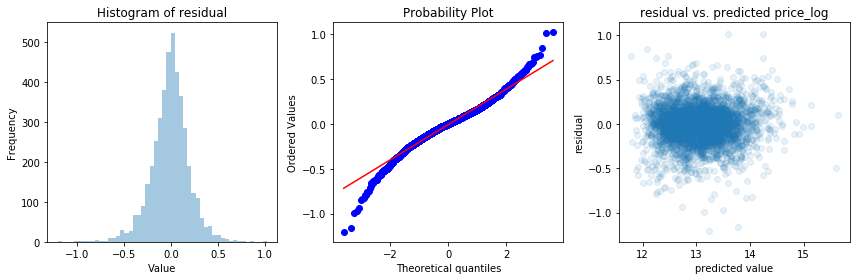

In [20]:
# residual diagnostic plots
fig, axs = plt.subplots(1,3, figsize=(12,4))
sns.distplot((y_test-y_pred_test_lr), kde=False,bins=50, ax=axs[0]);
axs[0].set_title('Histogram of residual')
axs[0].set_ylabel('Frequency')
axs[0].set_xlabel('Value')
ss.probplot((y_test-y_pred_test_lr), plot=axs[1])
axs[2].scatter(y_pred_test_lr, (y_test-y_pred_test_lr), alpha=0.1)
axs[2].set_ylabel('residual')
axs[2].set_xlabel('predicted value')
axs[2].set_title('residual vs. predicted price_log')
fig.tight_layout()
plt.show()

# compute RMSE, R2, adjusted R2 for test set
RMSE_test_lr = np.sqrt(mean_squared_error(y_test, y_pred_test_lr))
ntest = X_test.shape[0]
ptest = X_test.shape[1]
R2_test_lr = r2_score(y_test, y_pred_test_lr)
adjR2_test_lr = 1-(1-R2_test_lr)*(ntest-1)/(ntest-ptest-1)

# store parameter coefficients in dataframe
coeff_lr = pd.DataFrame(regressor.coef_,X.columns,columns=['sklearn'])

In [21]:
# 10-fold cross validation on train set (metric=RMSE)
cv_scores_lr = cross_val_score(regressor, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
cv_scores_lr_m = np.sqrt(-cv_scores_lr.mean())

# compute R2, adjusted R2 for train set
R2_train_lr = r2_score(y_train, y_pred_train_lr)
ntrain = X_train.shape[0]
ptrain = X_train.shape[1]
adjR2_train_lr = 1-(1-R2_train_lr)*(ntrain-1)/(ntrain-ptrain-1)

In [22]:
# model stats
#print('Cross-validated scores:', np.sqrt(-cv_scores_lr))
print('Mean cross-validated train RMSE: {}'.format(cv_scores_lr_m))
print('Adj R2 train:{}'.format(adjR2_train_lr))

print('\nRMSE test:{}'.format(RMSE_test_lr))
print('Adj R2 test:{}'.format(adjR2_test_lr))

Mean cross-validated train RMSE: 0.1964717111127902
Adj R2 train:0.861121272861001

RMSE test:0.20004950575103073
Adj R2 test:0.8561656768723335


In [23]:
# use statsmodels to get p-values of coefficients
# construct statsmodels model
X_train2 = sm.add_constant(X_train)
X_train2 = X_train2.as_matrix()
X_train2 = np.array(X_train2, dtype=float)

sm_model = sm.OLS(y_train, X_train2)
sm_result = sm_model.fit()
print(sm_result.summary())

/Users/lawrence/anaconda3/envs/tf/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/lawrence/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     1293.
Date:                Fri, 16 Aug 2019   Prob (F-statistic):               0.00
Time:                        10:34:07   Log-Likelihood:                 3710.0
No. Observations:               17290   AIC:                            -7252.
Df Residuals:                   17206   BIC:                            -6600.
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.4769      0.026    475.217      0.0

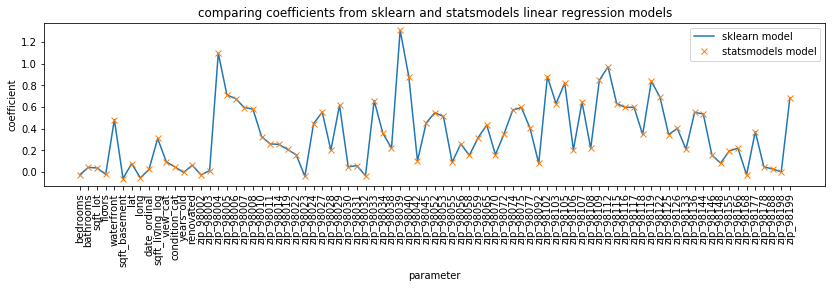

In [24]:
# graphically verify that coefficients are the same 
# between sklearn and statsmodels linear regression models
coeff_lr['sm'] = sm_result.params[1:].values

fig, ax = plt.subplots(figsize=(14,3))
ax.plot(coeff_lr['sklearn'], label='sklearn model')
ax.plot(coeff_lr['sm'],'x', label='statsmodels model')
ax.set_ylabel('coefficient')
ax.set_xlabel('parameter')
plt.xticks(rotation=90)
ax.legend()
plt.title('comparing coefficients from sklearn and statsmodels linear regression models')
plt.show()

In [25]:
# find parameter coefficients that are not significant
coeff_lr['pval'] =sm_result.pvalues[1:].values
print('parameter coefficients with p>0.05:\n{}'.format(coeff_lr[coeff_lr['pval']>0.05].index.to_list()))

parameter coefficients with p>0.05:
['years_old', 'zip_98002', 'zip_98003', 'zip_98032', 'zip_98168', 'zip_98178', 'zip_98188', 'zip_98198']


#### Baseline linear regression summary:
<ul>
    <li>From the residual diagnostic plots (histogram, Q-Q Normal plot, and residuals vs. predicted values): the residuals appear to be reasonably close a normal distribution, but deviations at the tails are evident and the Q-Q plot takes on an S-shape. The distribution of residuals does not change with predicted values.</li>
    <li>An adjusted R2 of 0.86 suggest that the model explains 86% of the variance of the original data and is a reasonable fit.</li>
    <li>Some parameters coefficients were not significant (p>0.05) suggesting that the model is overfitted. A regularized linear regression approach will be used next.</li>
</ul>

##### Regularized linear regression
Use elastic net, which linearly combines the L1 and L2 penalties of the lasso and ridge methods

In [26]:
# regularized linear regression using elastic net
elastic_net = ElasticNetCV(cv=10, l1_ratio=[.1, .5, .7, .9, .95, .99, 1], random_state=123)
elastic_net = elastic_net.fit(X_train, y_train)

y_pred_enet_cv = elastic_net.predict(X_train)
y_pred_enet_test = elastic_net.predict(X_test)

print('Optimal alpha: {}'.format(elastic_net.alpha_))
print('Optimal L1 ratio: {}'.format(elastic_net.l1_ratio_))

print('\nTrain RMSE: {}'.format(np.sqrt(mean_squared_error(y_train, y_pred_enet_cv))))
print('Test RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred_enet_test))))

#print('R2 train: {}'.format(r2_score(y_train, y_pred_enet_cv)))
#print('R2 test: {}'.format(r2_score(y_test, y_pred_enet_test)))

print('Adj R2 train: {}'.format(1-(1-r2_score(y_train, y_pred_enet_cv))*(ntrain-1)/(ntrain-ptrain-1)))
print('Adj R2 test: {}'.format(1-(1-r2_score(y_test, y_pred_enet_test))*(ntest-1)/(ntest-ptest-1)))

Optimal alpha: 0.00035376283039624193
Optimal L1 ratio: 1.0

Train RMSE: 0.1987527993815473
Test RMSE: 0.20274098490949946
Adj R2 train: 0.8560830394556105
Adj R2 test: 0.8522693283352283


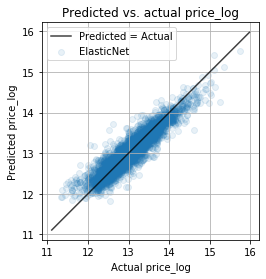

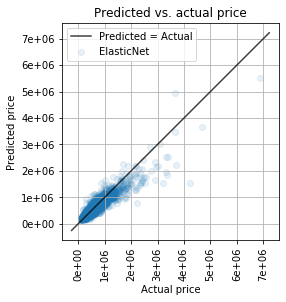

In [27]:
# predicted vs. observed plot
# price_log
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred_enet_test, label='ElasticNet', alpha=0.1)
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=10, label='Predicted = Actual')
ax.set_xlabel('Actual price_log')
ax.set_ylabel('Predicted price_log')
ax.set_title('Predicted vs. actual price_log')
ax.set_aspect('equal')
ax.legend()
ax.grid()
plt.show()

# price
fig, ax = plt.subplots()
ax.scatter(np.exp(y_test), np.exp(y_pred_enet_test), label='ElasticNet', alpha=0.1)
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=10, label='Predicted = Actual')
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
ax.set_xlabel('Actual price')
ax.set_ylabel('Predicted price')
ax.set_title('Predicted vs. actual price')
ax.set_aspect('equal')
ax.legend()
ax.grid()
ax.set_xticks(np.arange(0, ax.get_xlim()[1], 1e6))
ax.set_yticks(np.arange(0, ax.get_ylim()[1], 1e6))
plt.xticks(rotation=90)
plt.show()

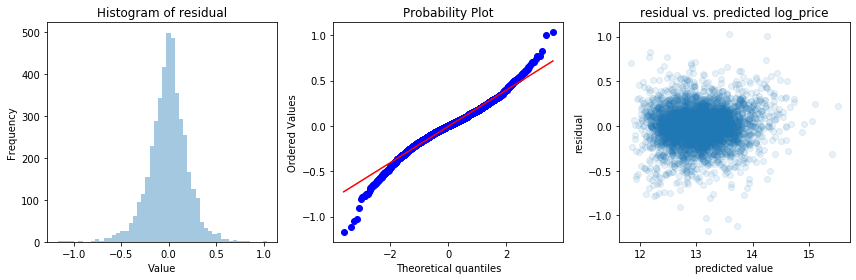

In [28]:
# residual diagnostic plots
fig, axs = plt.subplots(1,3, figsize=(12,4))
sns.distplot((y_test-y_pred_enet_test), kde=False,bins=50, ax=axs[0]);
axs[0].set_title('Histogram of residual')
axs[0].set_ylabel('Frequency')
axs[0].set_xlabel('Value')
ss.probplot((y_test-y_pred_enet_test), plot=axs[1])
axs[2].scatter(y_pred_enet_test, (y_test-y_pred_enet_test), alpha=0.1)
axs[2].set_ylabel('residual')
axs[2].set_xlabel('predicted value')
axs[2].set_title('residual vs. predicted log_price')
fig.tight_layout()
plt.show()

Total features: 83; Selected features: 74


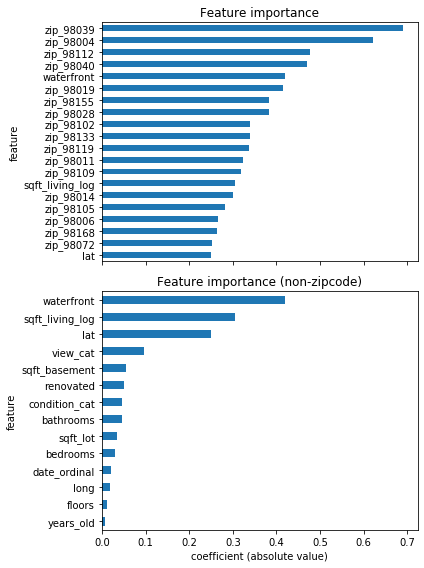

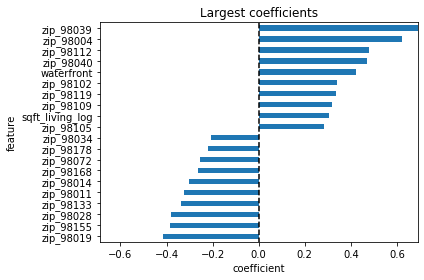

In [29]:
# evaluate feature importance based on coefficients
feat_imp = pd.Series(index = X_train.columns, data = np.abs(elastic_net.coef_))
# number of features with non-zero coefficients
n_selected_features = (feat_imp>0).sum()
print('Total features: {}; Selected features: {}'.format(X_train.shape[1], n_selected_features))
# number of features with non-zero coefficients, excluding zipcodes
non_zip_feat_imp = feat_imp[~feat_imp.index.str.startswith('z')]

# plot feature importantance/coefficients
fig, axs = plt.subplots(2,1, figsize=(6,8), sharex=True)
feat_imp.sort_values(ascending=False).head(20).plot(kind='barh', ax=axs[0])
non_zip_feat_imp.sort_values(ascending=False).plot(kind='barh', ax=axs[1])
for ax in axs:
    ax.invert_yaxis()
    ax.set_ylabel('feature')
    ax.set_xlabel('coefficient (absolute value)')
axs[0].set_title('Feature importance')
axs[1].set_title('Feature importance (non-zipcode)')
fig.tight_layout()
plt.show()

# plot largest coefficients (signed)
coeff_en = pd.Series(index = X_train.columns, data = elastic_net.coef_)
top10 = coeff_en.sort_values(ascending=False).head(10)
bot10 = coeff_en.sort_values(ascending=False).tail(10)
top10_bot10 = pd.concat([top10, bot10])
fig, ax = plt.subplots(figsize=(6,4))
top10_bot10.plot(kind='barh', ax=ax)
ax.invert_yaxis()
ax.set_xlim(-np.abs(top10_bot10).max(), np.abs(top10_bot10).max())
ax.set_ylabel('feature')
ax.set_xlabel('coefficient')
ax.set_title('Largest coefficients')
ax.axvline(x=0, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='k', ls='--')
fig.tight_layout()
plt.show()

#### Regularized linear regression (Elastic net) summary:
<ul>
    <li>From the residual diagnostic plots (histogram, Q-Q Normal plot, and residuals vs. predicted values): the residuals appear to be reasonably close a normal distribution, but deviations at the tails are evident and the Q-Q plot takes on an S-shape. The distribution of residuals does not change with predicted values.</li>
    <li>An adjusted R2 of 0.86 suggest that the model explains 86% of the variance of the original data and is a reasonable fit.</li>
    <li>The optimal L1 ratio of 1 suggests that the LASSO solution is optimal. Elastic net selected 74 of the 83 features.</li>
    <li>Overall, predicted results and model statistics are very similar to the baseline linear regression model.</li>
</ul>

#### Overall summary
#### To predict house prices:
<ul>
    <li>The data was prepared, including feature engineering (based on EDA from Milestone 1), normalization, and encoding</li>
    <li>Two models (a linear regression model and a regularized linear regression model using elastic net) were constructed and evaluated</li>
</ul>